In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Define basic data

In [5]:
# define the years to be classified
year_name  = list([f'{span[0]}_{span[1]}' for span in zip(range(1990,2020,3),range(1992,2020,3)) ])

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized'

# Use the Invarient points to compute the classification accuracy
Invarient_non_built_sample = [ee.FeatureCollection(f'{path}/Invarient_non_built_{year}')\
                                .filterMetadata('Built','equals',0) for year in year_name]
Invarient_built_sample     = [ee.FeatureCollection(f'{path}/Invarient_built_{year}')
                                for year in year_name]
Invarient_sample_merge     = [i[0].merge(i[1]) for i in zip(Invarient_non_built_sample,
                                                            Invarient_built_sample)]

##### Calculate the accuracy of my result at each year

In [7]:
Classificatioin_ACC = {}

for year,sample in zip(year_name,Invarient_sample_merge):
    
    all_bands = list(sample.first().getInfo()['properties'].keys())
    all_bands.remove('Built')
    
    # Instatiate the class with a name.
    classification = Classification(year_name      = year,
                                    Verified_point = sample,
                                    Input_img      = None,
                                    Input_band     = all_bands,
                                    Tree_num       = 100,
                                    Zone_sample    = None,
                                    classProperty  = 'Built')


    # perform the classification on Samples
    classification.Stp_2_Classification_on_Samples()

    # Get the classified samples
    train_sample_classified        = classification.Train_sample_classification
    test_sample_classified         = classification.Test_sample_classification
    
    # Compute the accuracy
    test_acc = Accuracy_assesment(test_sample_classified).Stp_1_Calculate_Accuracy()
    
    # add classfication into the list
    Classificatioin_ACC[year] = test_acc
    
    # print out the process
    print(f'Accuracy computation of {year} complete!')

Accuracy computation of 1990_1992 complete!
Accuracy computation of 1993_1995 complete!
Accuracy computation of 1996_1998 complete!
Accuracy computation of 1999_2001 complete!
Accuracy computation of 2002_2004 complete!
Accuracy computation of 2005_2007 complete!
Accuracy computation of 2008_2010 complete!
Accuracy computation of 2011_2013 complete!
Accuracy computation of 2014_2016 complete!
Accuracy computation of 2017_2019 complete!


In [8]:
My_acc_df = pd.DataFrame(Classificatioin_ACC).T
My_acc_df.index.name = 'Year'

#### Calculate the accuracy of GAIA datasets

In [9]:
GAIA = ee.Image("users/wangjinzhulala/Gloable_Imprevious_area").clip(North_China_Plain)

In [17]:
# link the year with its pixel value
GAIA_year = range(1985,2019)
GAIA_id   = range(34,0,-1)
GAIA_corr = {i[0]:i[1] for i in zip(GAIA_year,GAIA_id)}

Fourier_end_years = list(range(1992,2018,3)) + [2018]

In [19]:
GAIA_corr

{1985: 34,
 1986: 33,
 1987: 32,
 1988: 31,
 1989: 30,
 1990: 29,
 1991: 28,
 1992: 27,
 1993: 26,
 1994: 25,
 1995: 24,
 1996: 23,
 1997: 22,
 1998: 21,
 1999: 20,
 2000: 19,
 2001: 18,
 2002: 17,
 2003: 16,
 2004: 15,
 2005: 14,
 2006: 13,
 2007: 12,
 2008: 11,
 2009: 10,
 2010: 9,
 2011: 8,
 2012: 7,
 2013: 6,
 2014: 5,
 2015: 4,
 2016: 3,
 2017: 2,
 2018: 1}

In [11]:
# Here use the Classification class to perform the train/test split
# and get the test samples.

Sample_classificaiton = Classification( # input year_name does not affect train/test split
                                        year_name      = 'any',
    
                                        # Use the first Invariant sample is OK
                                        Verified_point = Invarient_sample_merge[0],
                                        Input_img      = None,
                                        # Just need ['Built'] information
                                        Input_band     = ['Built'],
                                        Tree_num       = 100,
                                        Zone_sample    = None,
                                        classProperty  = 'Built')

test_sample = classification.Verified_pts_test

In [12]:
GAIA_acc = {}

for i,end_year in enumerate(Fourier_end_years):
    
    # get the sample point
    Invariant_sample = Invarient_sample_merge[i]
    
    # get the pixel value of coresponded end_year
    # rename the GAIA to 'classificaiton' so that the name
    # is consistent with the Accuracy_assessment module
    GAIA_pixel_value = GAIA_corr[end_year]
    
    # conver pixel value greater than GAIA_pixel_value to 0,other pixel to 1
    # so we get all target-year pixel with value 1
    GAIA_within_year = GAIA.gt(GAIA_pixel_value).rename('classification')
    
    # extract reclassified GAIA pixel value to test_sample
    test_with_GAIA = GAIA_within_year.sampleRegions(collection = test_sample, 
                                                    properties = ['Built'], 
                                                    scale      = 30)
    # compute the accuracy 
    GAIA_acc[end_year] = Accuracy_assesment(test_with_GAIA).Stp_1_Calculate_Accuracy()
    
    # print out the process
    print(f'Accuracy computation of {end_year} complete!')
    

Accuracy computation of 1992 complete!
Accuracy computation of 1995 complete!
Accuracy computation of 1998 complete!
Accuracy computation of 2001 complete!
Accuracy computation of 2004 complete!
Accuracy computation of 2007 complete!
Accuracy computation of 2010 complete!
Accuracy computation of 2013 complete!
Accuracy computation of 2016 complete!
Accuracy computation of 2018 complete!


In [13]:
GAIA_acc_df = pd.DataFrame(GAIA_acc).T
GAIA_acc_df.index.name = 'End_year'

##### Save the acc_df to local disk

In [14]:
# reset index so can drwo them togeter
# My_acc_df.reset_index(inplace=True)
# GAIA_acc_df.reset_index(inplace=True)

# My_acc_df.to_csv('ACC_Result/My_accuracy.csv',index=False)
# GAIA_acc_df.to_csv('ACC_Result/GAIA_accuracy.csv',index=False)

In [5]:
My_acc_df = pd.read_csv('ACC_Result/My_accuracy.csv')
GAIA_acc_df = pd.read_csv('ACC_Result/GAIA_accuracy.csv')

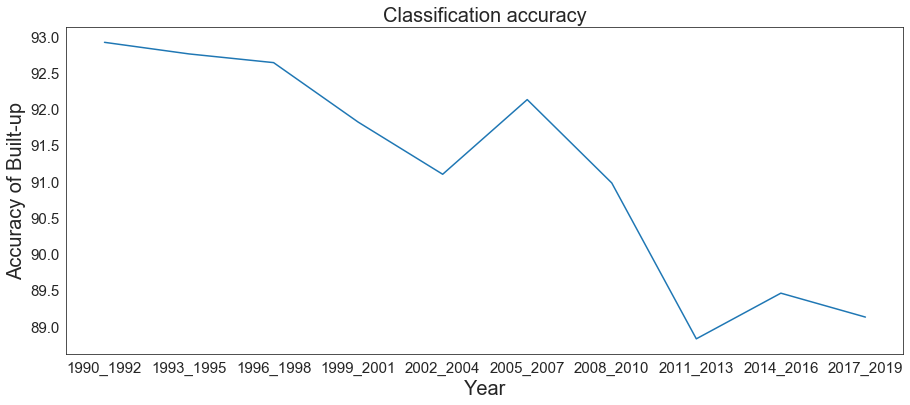

In [8]:
plt.figure(figsize=(15, 6))

plt.ylabel = 'Recall accuracy of built-up'
sns.set_style("white")
b = sns.lineplot(x='Year',y='Recall_built',data=My_acc_df)

b.axes.set_title("Classification accuracy",fontsize=20)
b.set_xlabel("Year",fontsize=20)
b.set_ylabel("Accuracy of Built-up",fontsize=20)
b.tick_params(labelsize=15)

In [4]:
My_acc_df

,Year,Overall_ACC,Precisioin_built,Precisioin_non_built,Recall_built,Recall_non_built
0,1990_1992,92.52,92.08,92.96,92.92,92.13
1,1993_1995,93.21,93.73,92.69,92.76,93.67
2,1996_1998,93.02,93.38,92.66,92.64,93.40
3,1999_2001,92.63,93.52,91.75,91.82,93.47
4,2002_2004,92.13,93.06,91.23,91.10,93.16
5,2005_2007,93.22,94.29,92.17,92.13,94.32
6,2008_2010,90.82,90.71,90.94,90.98,90.67
7,2011_2013,90.57,92.15,89.08,88.83,92.33
8,2014_2016,90.96,92.31,89.68,89.46,92.48
9,2017_2019,91.42,93.71,89.28,89.13,93.79


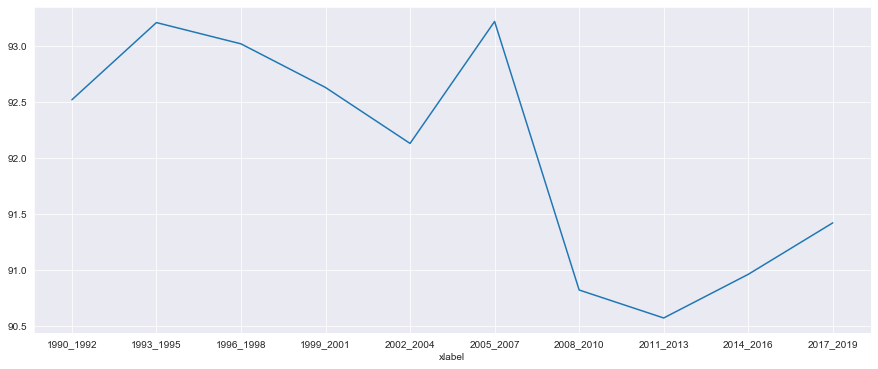

In [17]:
fig = plt.figure(figsize=(15, 6))


plt.plot(My_acc_df['Year'],My_acc_df['Overall_ACC'])
plt.xlabel('xlabel')
plt.ylabel = 'Recall accuracy of built-up'

In [11]:
GAIA_acc_df['Type'] = ['GAIA'] * 10
My_acc_df['Type'] = ['My_result'] * 10
GAIA_acc_df['Year'] = My_acc_df['Year']
pd_figure = My_acc_df.append(GAIA_acc_df)


[None, None]

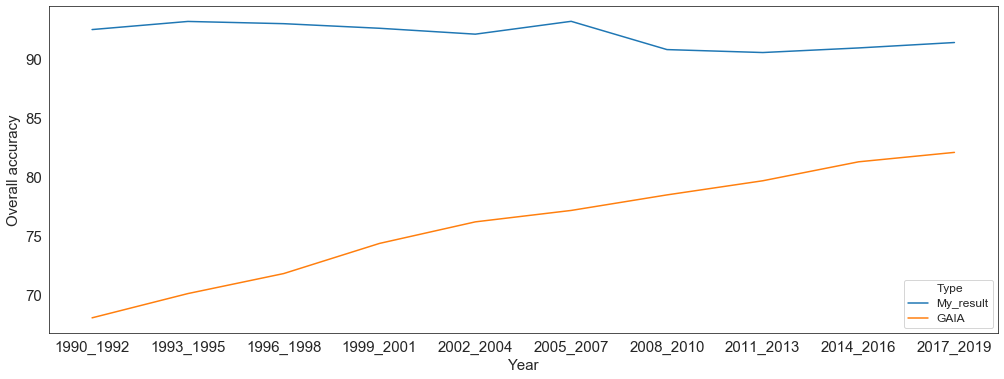

In [16]:
plt.figure(figsize=(17,6))
b = sns.lineplot(x='Year',y='Overall_ACC',data=pd_figure,hue = 'Type')

b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Overall accuracy",fontsize=15)
b.tick_params(labelsize=15)

plt.setp(b.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(b.get_legend().get_title(), fontsize='12') # for legend title